# STAR CLUSTER ANALYSIS

## Visualising the Galaxy

In [1]:
from astroquery.gaia import Gaia
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
query='''
SELECT top 50000 ra,dec,phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax IS NOT NULL
AND parallax>0 AND parallax_over_error>10
ORDER BY phot_g_mean_mag ASC
'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
from scipy.stats import gaussian_kde
import astropy.units as u
import astropy.time
import astropy.coordinates

coords_ra=[]
coords_dec=[]
for i in range(len(r['ra'])):
    coords=astropy.coordinates.SkyCoord(ra=r['ra'][i]*u.deg,dec=r['dec'][i]*u.deg,frame='icrs')
    coords= coords.transform_to(astropy.coordinates.Galactic())
    coords_ra.append(coords.l.deg)
    coords_dec.append(coords.b.deg)

In [4]:
kde = gaussian_kde(np.vstack([coords_ra, coords_dec]))
density = kde(np.vstack([coords_ra, coords_dec]))

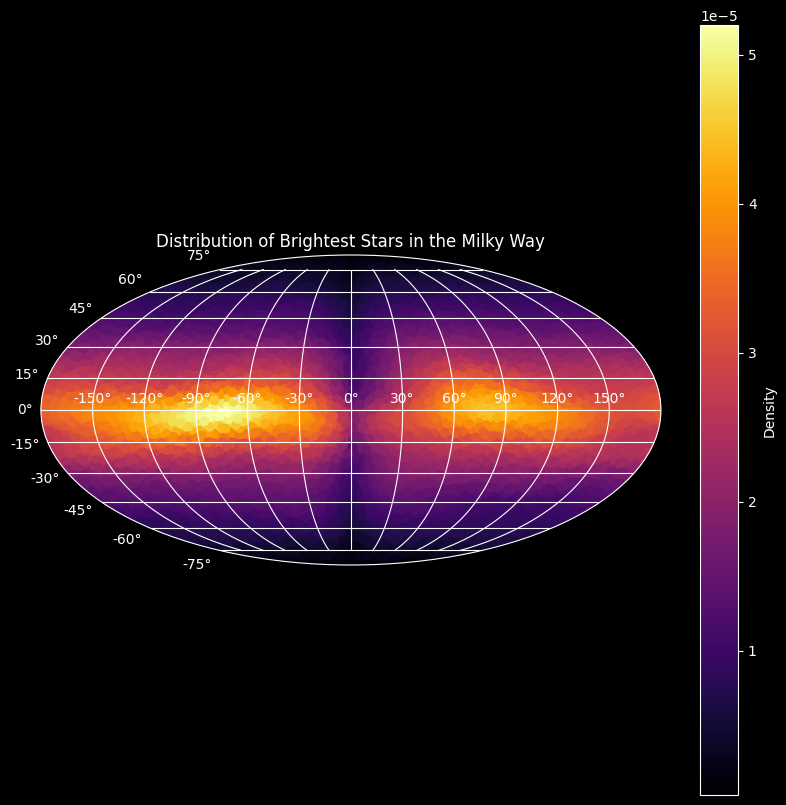

In [5]:
for i in range(len(coords_ra)):
    if coords_ra[i]>180:
        coords_ra[i]=coords_ra[i]-360

with plt.style.context('dark_background'):
    plt.figure(figsize=(10,10))
    plt.subplot(111, projection='mollweide')
    plt.scatter(np.radians(coords_ra),np.radians(coords_dec),c=density, cmap='inferno')
    plt.colorbar(label='Density')
    plt.title('Distribution of Brightest Stars in the Milky Way')
    plt.grid(True)
plt.show()

### King Cobra Cluster

In [6]:
#Convert RA in hms to dd and Dec in dms to dd

def convert_RA(RA):
    hms=[float(i) for i in RA.split()]
    return 15*(hms[0]+hms[1]/60+hms[2]/3600)

def convert_Dec(Dec):
    dms=[float(i) for i in Dec.split()]
    if dms[0]>0:
        return dms[0]+dms[1]/60+dms[2]/3600
    return dms[0]-(float(dms[1])/60)-(float(dms[2])/3600)

#Coordinates
ra=convert_RA('8 50.4 0')
dec=convert_Dec('+11 49 0')
print(ra,dec)

132.6 11.816666666666666


In [7]:
query='''
SELECT top 100000 source_id,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra,pmdec
FROM gaiadr3.gaia_source
WHERE ra BETWEEN 132.2 AND 133.0 AND
dec BETWEEN 11.4 AND 12.3
AND parallax IS NOT NULL
AND parallax_over_error>5
ORDER BY source_id
'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


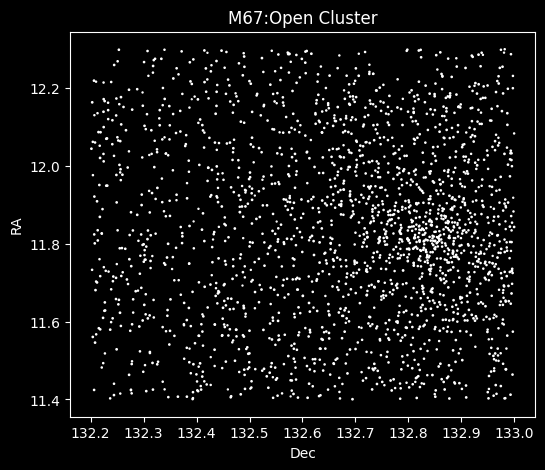

In [8]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6,5))
    plt.scatter(r['ra'],r['dec'],s=0.05*abs(r['phot_g_mean_mag']),color='white')
    plt.xlabel('Dec')
    plt.ylabel('RA')
    plt.title('M67:Open Cluster') 
    plt.show()

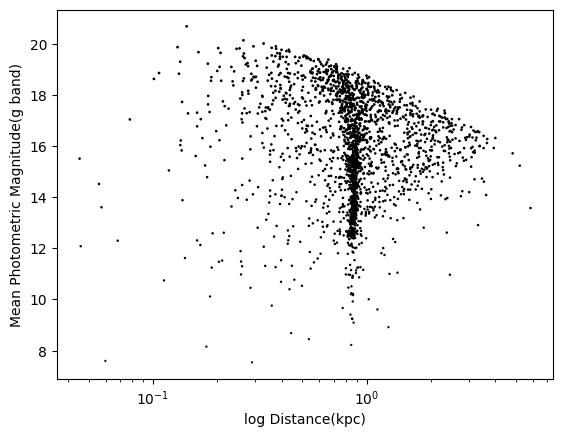

In [9]:
distance=np.reciprocal(r['parallax'])
plt.scatter(distance,r['phot_g_mean_mag'],s=0.05*abs(r['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.show()

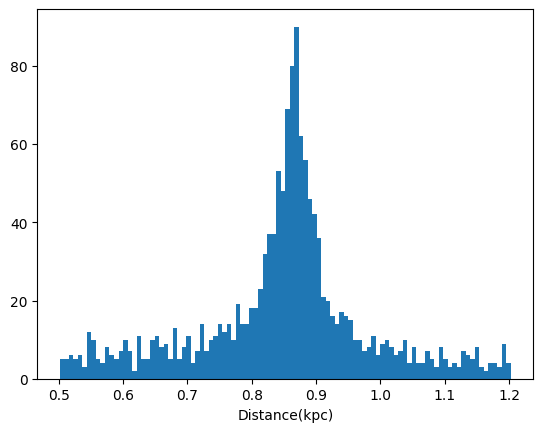

In [10]:
filter_up= r['parallax']>0.83
filter_down=r['parallax']<2
filtered=np.logical_and(filter_up,filter_down)
r_filtered=r[filtered]

distance_filtered=1/r_filtered['parallax']
n,bins=np.histogram(distance_filtered,bins=100)
plt.hist(distance_filtered,bins=100)
plt.xlabel('Distance(kpc)')
plt.show()

In [11]:
x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)

def gaussian(x,disp,amp,mu,sigma):
    return disp+amp*norm.pdf(x,mu,sigma)

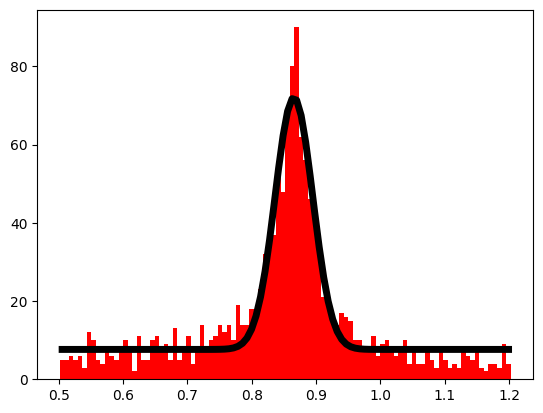

Distance estimate in kpc: 0.8655866416950981
Std Dev: 0.029285477384044228


In [12]:
popt,pcov=curve_fit(gaussian,x_array,n,p0=(0,20,0.8,0.1))

plt.plot(x_array,gaussian(x_array,popt[0],popt[1],popt[2],popt[3]),linewidth=5,color='black')
plt.hist(distance_filtered,bins=100,color='red')
plt.show()

print('Distance estimate in kpc:',popt[2])
print('Std Dev:',popt[3])

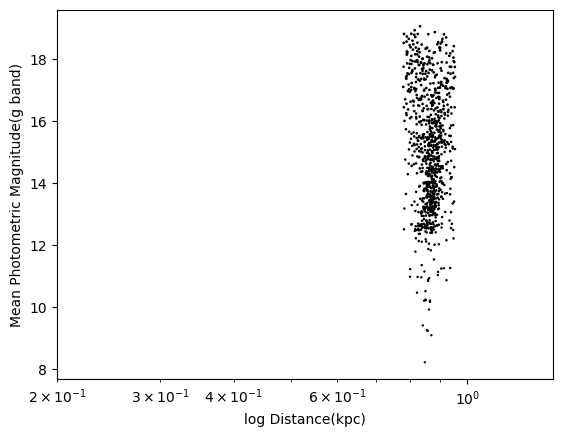

In [13]:
# Retain stars within 3*stdev to pick stars from the cluster
distance=0.8655866416950981
std=0.029285477384044228

filter2_up=r_filtered['parallax']<1/(distance-3*std)
filter2_down=r_filtered['parallax']>1/(distance+3*std)
filter2=np.logical_and(filter2_up,filter2_down)
data_cobra=r_filtered[filter2]

plt.scatter(1/data_cobra['parallax'],data_cobra['phot_g_mean_mag'],s=0.05*abs(data_cobra['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.xlim(0.2,1.4)
plt.show()

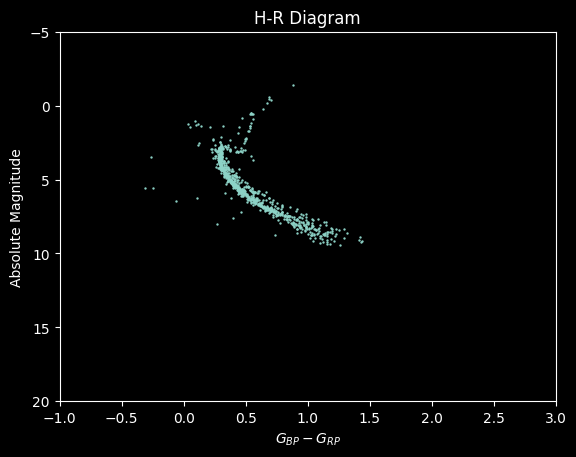

In [14]:
abs_mag_cobra=data_cobra['phot_g_mean_mag']-5*np.log10(100/(data_cobra['parallax']))    
xaxis_cobra=data_cobra['phot_bp_mean_mag']-data_cobra['phot_g_mean_mag']

with plt.style.context('dark_background'):
    plt.scatter(xaxis_cobra,abs_mag_cobra,s=0.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
plt.show()

### Beehive Cluster

In [15]:
# Beehive Cluster(open cluster)
print(convert_RA('8 40 24'),convert_Dec('19 59 0')) 

130.09999999999997 19.983333333333334


In [16]:
query='''
SELECT top 100000 source_id,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra,pmdec
FROM gaiadr3.gaia_source
WHERE ra BETWEEN 129 AND 131 AND
dec BETWEEN 19 AND 21
AND parallax IS NOT NULL
ORDER BY source_id
'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


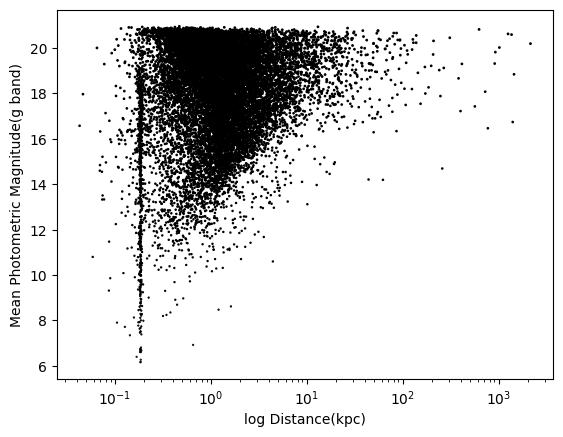

In [17]:
distance=1/r['parallax']
plt.scatter(distance,r['phot_g_mean_mag'],s=0.05*abs(r['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.show()

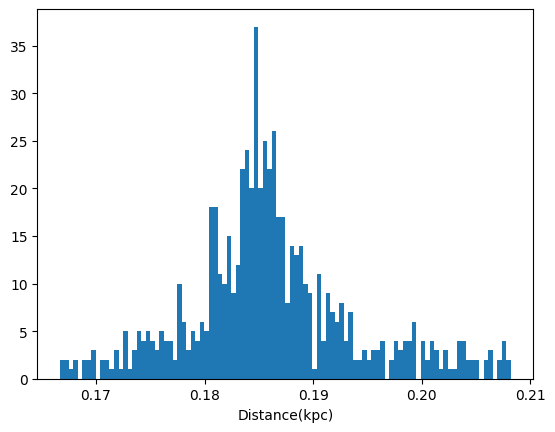

Approximate distance to cluster: 0.18453476144937525 kpc
Actual distance:187 pc


In [18]:
# Pick stars close to the overdensity

filter_up= r['parallax']>4.8
filter_down=r['parallax']<6
filtered=np.logical_and(filter_up,filter_down)
r_filtered=r[filtered]

distance_filtered=1/r_filtered['parallax']
n,bins=np.histogram(distance_filtered,bins=100)
plt.hist(distance_filtered,bins=100)
plt.xlabel('Distance(kpc)')
plt.show()
print('Approximate distance to cluster:',bins[np.argmax(n)],'kpc')
print('Actual distance:187 pc')

In [19]:
x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)

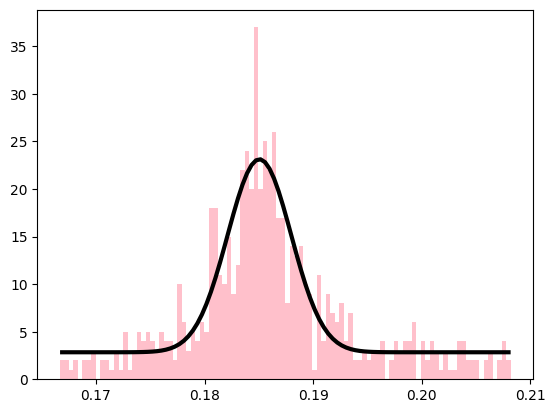

Distance estimate in kpc: 0.1850542578417557
Std Dev: 0.0029303155725327514


In [20]:
popt,pcov=curve_fit(gaussian,x_array,n,p0=(0,20,0.18,0.1))

plt.plot(x_array,gaussian(x_array,popt[0],popt[1],popt[2],popt[3]),linewidth=3,color='black')
plt.hist(distance_filtered,bins=100,color='pink')
plt.show()

print('Distance estimate in kpc:',popt[2])
print('Std Dev:',popt[3])

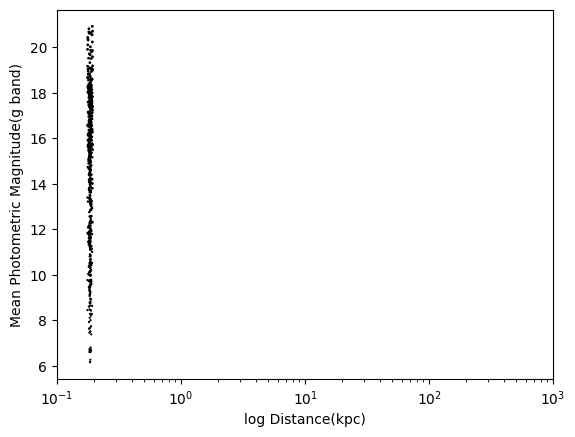

In [21]:
# Retain stars within 3*stdev to pick stars from the cluster
distance=0.18498464099359377
std=0.003002907187237187
filter2_up=r_filtered['parallax']<1/(distance-3*std)
filter2_down=r_filtered['parallax']>1/(distance+3*std)
filter2=np.logical_and(filter2_up,filter2_down)
data_beehive=r_filtered[filter2]

plt.scatter(1/data_beehive['parallax'],data_beehive['phot_g_mean_mag'],s=0.05*abs(data_beehive['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.xlim(0.1,1000)
plt.show()

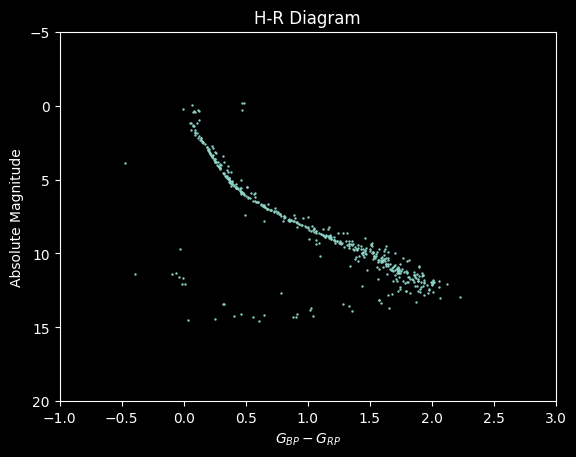

In [22]:
abs_mag_beehive=data_beehive['phot_g_mean_mag']-5*np.log10(100/(data_beehive['parallax']))    
xaxis_beehive=data_beehive['phot_bp_mean_mag']-data_beehive['phot_g_mean_mag']

with plt.style.context('dark_background'):
    plt.scatter(xaxis_beehive,abs_mag_beehive,s=0.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
plt.show()

### Alpha Persei

In [23]:
print(convert_RA('3 26 42'),convert_Dec('48 48 0')) 

51.675000000000004 48.8


In [24]:
query='''
SELECT top 100000 source_id,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra,pmdec
FROM gaiadr3.gaia_source
WHERE ra BETWEEN 50 AND 52.5 AND
dec BETWEEN 48 AND 59.5
AND parallax IS NOT NULL AND parallax_over_error>10
ORDER BY parallax DESC
'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


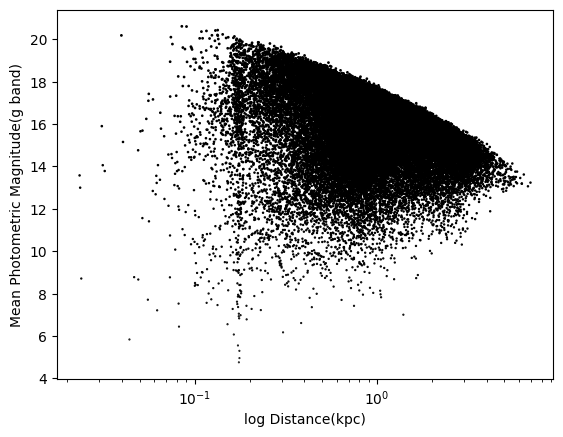

In [25]:
distance=1/r['parallax']
plt.scatter(distance,r['phot_g_mean_mag'],s=0.05*abs(r['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.show()

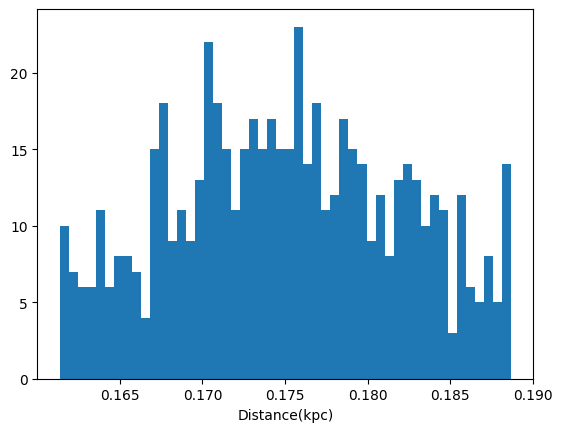

Approximate distance to cluster: 0.17556647445989887 kpc
Actual distance:175 pc


In [26]:
# Pick stars close to the overdensity

filter_up= r['parallax']>5.3
filter_down=r['parallax']<6.2
filtered=np.logical_and(filter_up,filter_down)
r_filtered=r[filtered]

distance_filtered=1/r_filtered['parallax']
n,bins=np.histogram(distance_filtered,bins=50)
plt.hist(distance_filtered,bins=50)
plt.xlabel('Distance(kpc)')
plt.show()
print('Approximate distance to cluster:',bins[np.argmax(n)],'kpc')
print('Actual distance:175 pc')

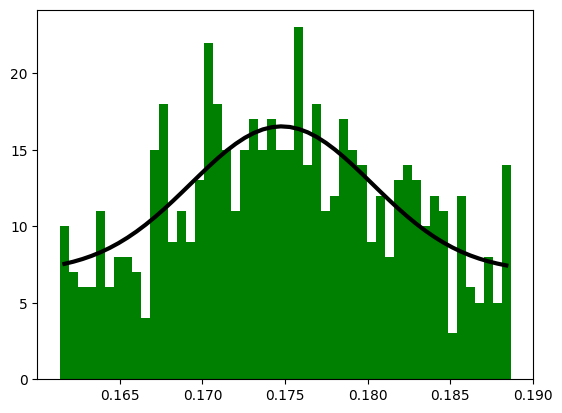

Distance estimate in kpc: 0.17478668633862432
Std Dev: 0.005490830635626479


In [27]:
x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)
    
popt,pcov=curve_fit(gaussian,x_array,n,p0=(0,20,0.18,0.1))

plt.plot(x_array,gaussian(x_array,popt[0],popt[1],popt[2],popt[3]),linewidth=3,color='black')
plt.hist(distance_filtered,bins=50,color='green')
plt.show()

print('Distance estimate in kpc:',popt[2])
print('Std Dev:',popt[3])

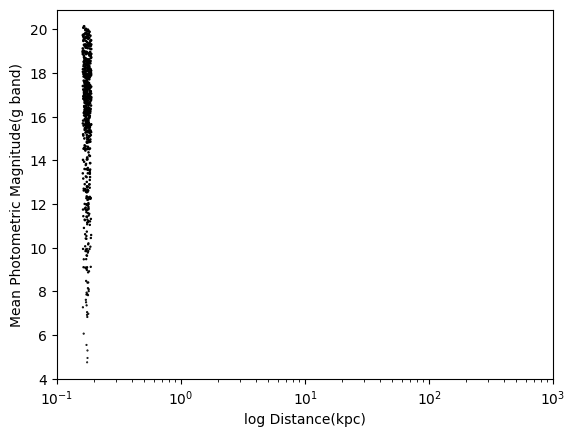

In [28]:
# Retain stars within 3*stdev to pick stars from the cluster
distance=0.17478668633862432
std=0.005490830635626479
filter2_up=r_filtered['parallax']<1/(distance-3*std)
filter2_down=r_filtered['parallax']>1/(distance+3*std)
filter2=np.logical_and(filter2_up,filter2_down)
data_alphapersei=r_filtered[filter2]

plt.scatter(1/data_alphapersei['parallax'],data_alphapersei['phot_g_mean_mag'],s=0.05*abs(data_alphapersei['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.xlim(0.1,1000)
plt.show()

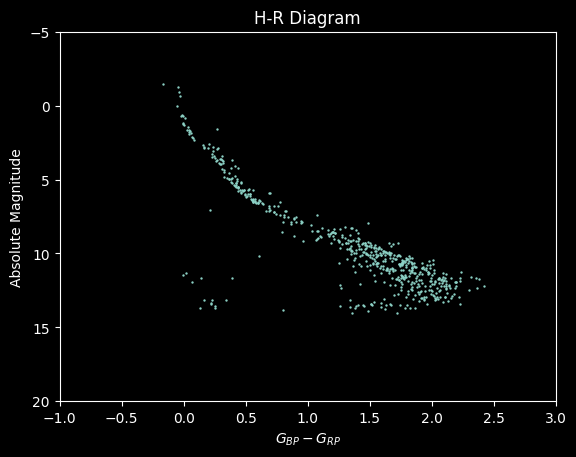

In [29]:
abs_mag_alphapersei=data_alphapersei['phot_g_mean_mag']-5*np.log10(100/(data_alphapersei['parallax']))    
xaxis_alphapersei=data_alphapersei['phot_bp_mean_mag']-data_alphapersei['phot_g_mean_mag']

with plt.style.context('dark_background'):
    plt.scatter(xaxis_alphapersei,abs_mag_alphapersei,s=0.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
plt.show()

### Christmas Tree Cluster

In [30]:
print(convert_RA('6 41 0'),convert_Dec('9 53 0')) 

100.25 9.883333333333333


In [31]:
query='''
SELECT top 100000 source_id,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra,pmdec
FROM gaiadr3.gaia_source
WHERE ra BETWEEN 100 AND 100.5 AND
dec BETWEEN 9.5 AND 10.5
AND parallax IS NOT NULL AND parallax_over_error>5
ORDER BY parallax_over_error DESC
'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


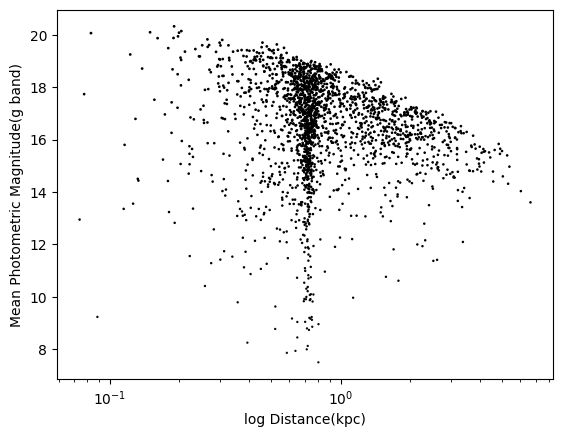

In [32]:
distance=1/r['parallax']
plt.scatter(distance,r['phot_g_mean_mag'],s=0.05*abs(r['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.show()

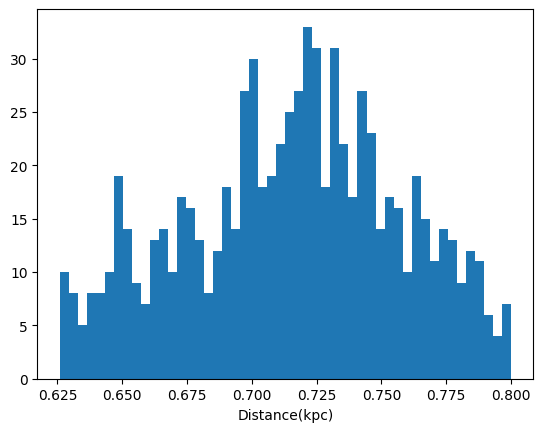

Approximate distance to cluster: 0.7198914359770251 kpc
Actual distance:720 pc


In [33]:
# Pick stars close to the overdensity

filter_up= r['parallax']>1.25
filter_down=r['parallax']<1.6
filtered=np.logical_and(filter_up,filter_down)
r_filtered=r[filtered]

distance_filtered=1/r_filtered['parallax']
n,bins=np.histogram(distance_filtered,bins=50)
plt.hist(distance_filtered,bins=50)
plt.xlabel('Distance(kpc)')
plt.show()
print('Approximate distance to cluster:',bins[np.argmax(n)],'kpc')
print('Actual distance:720 pc')

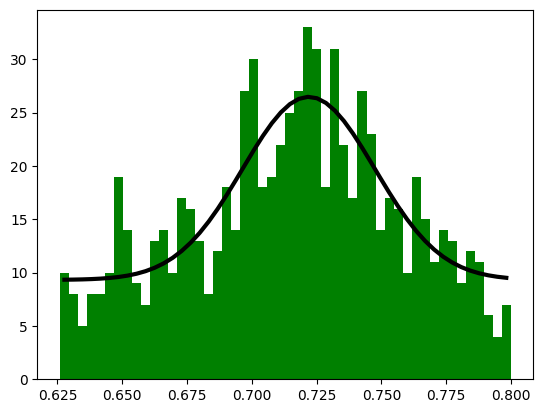

Distance estimate in kpc: 0.7219526483577975
Std Dev: 0.025525278926398984


In [34]:
x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)
    
popt,pcov=curve_fit(gaussian,x_array,n,p0=(0,30,0.7,0.1))

plt.plot(x_array,gaussian(x_array,popt[0],popt[1],popt[2],popt[3]),linewidth=3,color='black')
plt.hist(distance_filtered,bins=50,color='green')
plt.show()

print('Distance estimate in kpc:',popt[2])
print('Std Dev:',popt[3])

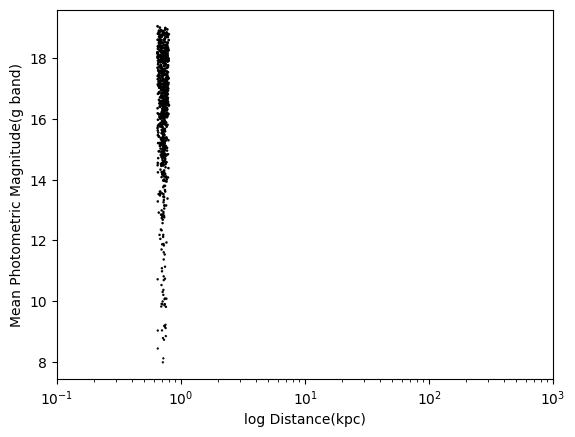

In [35]:
# Retain stars within 3*stdev to pick stars from the cluster
distance=0.7219526483577975
std=0.025525278926398984
filter2_up=r_filtered['parallax']<1/(distance-3*std)
filter2_down=r_filtered['parallax']>1/(distance+3*std)
filter2=np.logical_and(filter2_up,filter2_down)
data_ct=r_filtered[filter2]

plt.scatter(1/data_ct['parallax'],data_ct['phot_g_mean_mag'],s=0.05*abs(data_ct['phot_g_mean_mag']),color='black')
plt.xlabel('log Distance(kpc)')
plt.ylabel('Mean Photometric Magnitude(g band)')
plt.xscale('log')
plt.xlim(0.1,1000)
plt.show()

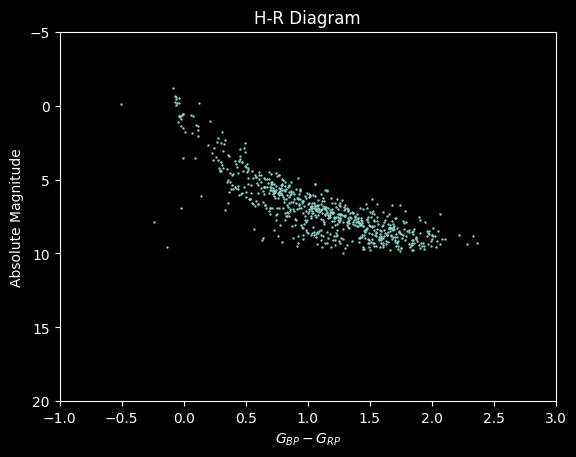

In [36]:
abs_mag_ct=data_ct['phot_g_mean_mag']-5*np.log10(100/(data_ct['parallax']))    
xaxis_ct=data_ct['phot_bp_mean_mag']-data_ct['phot_g_mean_mag']

with plt.style.context('dark_background'):
    plt.scatter(xaxis_ct,abs_mag_ct,s=0.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
plt.show()

## Hertzsprung-Russell Diagrams
(Colour Magnitude Plots)

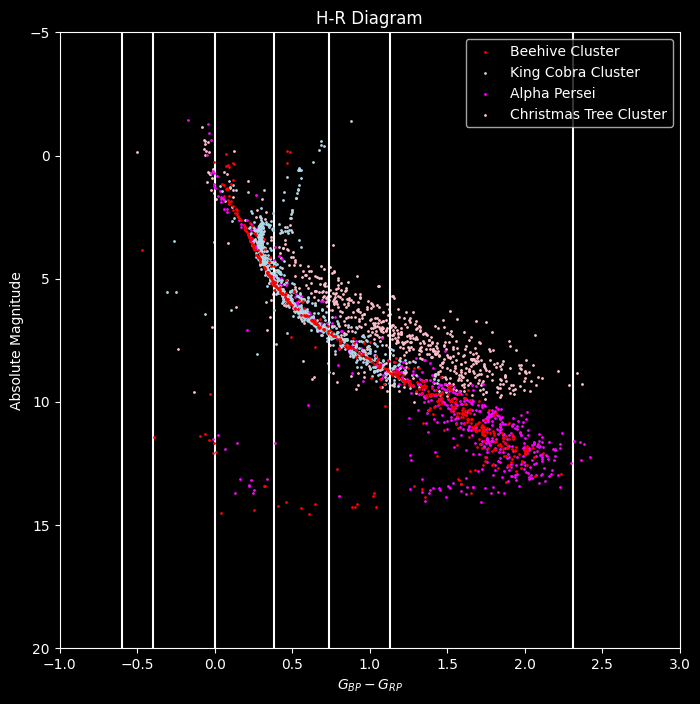

In [37]:
data=[data_beehive,data_cobra,data_alphapersei,data_ct]
abs_mag=[abs_mag_beehive,abs_mag_cobra,abs_mag_alphapersei,abs_mag_ct]
xaxis=[xaxis_beehive,xaxis_cobra,xaxis_alphapersei,xaxis_ct]

                  
colours=['red','lightblue','magenta','pink']
names=['Beehive Cluster','King Cobra Cluster','Alpha Persei','Christmas Tree Cluster']
spectral_classes=['O','B','A','F','G','K','M']
spectral_class_temps=[ -0.6, -0.4, 0, 0.38, 0.74, 1.13, 2.31]
ydata=np.linspace(-5,20,10)

with plt.style.context('dark_background'):
    plt.figure(figsize=(8,8))
    for i in range(len(data)):
        plt.scatter(xaxis[i],abs_mag[i],color=colours[i],label=names[i],s=1,zorder=5-i)
    for i in range(len(spectral_classes)):
        plt.plot(np.full((10,1),spectral_class_temps[i]),ydata,color='white')
        plt.annotate(spectral_classes[i],(spectral_class_temps[i],-25))
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
    plt.legend()
plt.show()

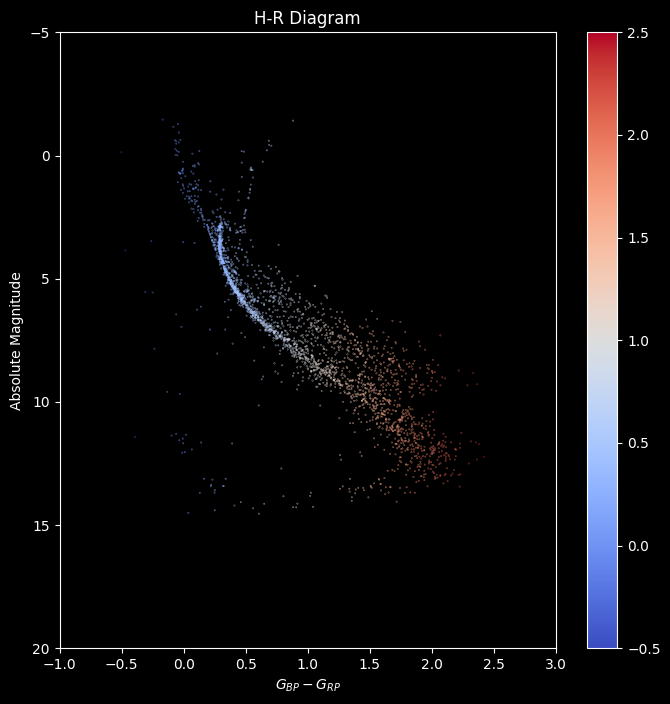

In [38]:
from astropy.table import vstack
all_data=vstack([data_beehive,data_cobra,data_alphapersei,data_ct])

xdata=all_data['phot_bp_mean_mag']-all_data['phot_g_mean_mag']
ydata=all_data['phot_g_mean_mag']-5*np.log10(100/(all_data['parallax']))

with plt.style.context('dark_background'):
    plt.figure(figsize=(8,8))
    plt.scatter(xdata,ydata,c=xdata,s=0.05,cmap='coolwarm',vmin=-0.5, vmax=2.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
    plt.colorbar()
plt.show()